<center>

# Evaluating Spatial Accessibility and Social Equity of Urban Public Facilities: A Case Study in New York City

## Final Project: ST445-Managing and Visualizing Data, 24/25

### Candidates: 45293, 

</center>


## Prerequisites of Notebook

TODO

1. Python>=3.10
2. Install the latest Geopandas package

In [152]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from sodapy import Socrata
from shapely.geometry import shape
import osmnx as ox
import shapely
from shapely.geometry import LineString
from shapely.ops import snap, linemerge

## Content <br><br>

* [**1. Introduction**](#1)
    * [1.1 Research Background](#1_1)
    * [1.2 Research Questions and Objectives](#1_2)
    * [1.3 Description of Dataset](#1_3)
* [**2. Data Acquisiton and Preprocessing**](#2)
    * [2.1 The Boundaries of NYC by Boroughs and Census Tracts](#2_1)
    * [2.2 Roads and Streets in NYC](#2_2)
    * [2.3 Geographical Points of Public Facilities](#2_3)
    * [2.4 Socio-economic Indicators from ACS](#2_4)
    * [2.5 Other Indicators Generated by Current Geospatial Data](#2_5)
* [**3. Data Visualization and Analysis**](#3)
    * [3.1 Spatial Accessibility Distribution of Different Public Facilities](#3_1)
    * [3.2 Equity Assessment of Different Boroughs](#3_2)
    * [3.3 Equity Assessment of Different Demographic Groups](#3_3)
    * [3.4 Evaluation of Socio-economic Factors’ Impact on Accessibility](#3_4)
* [**4. Conclusion**](#4)
* [**References**](#5)

<a id="1"></a>
## **1. Introduction**


<a id="1_1"></a>
### 1.1 Research Background


<a id="1_2"></a>
### 1.2 Research Questions and Objectives

<a id="1_3"></a>
### 1.3 Description of Dataset

<a id="2"></a>
## **2. Data Acquisiton and Preprocessing**


<a id="2_1"></a>
### 2.1 The Boundaries of NYC by Boroughs and Census Tracts

#### [The Boundaries of Boroughs in NYC](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)



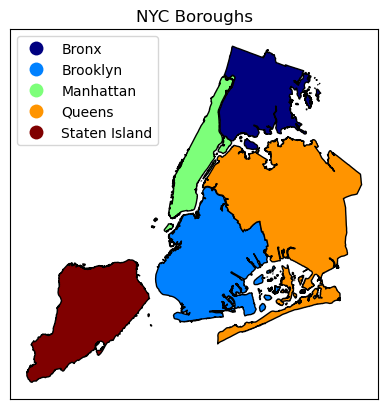

In [107]:
import matplotlib.patches as mpatches
# TODO: kMA3pLN5r66BAnhG4hQvEr8Mi is my own token
client = Socrata("data.cityofnewyork.us", "kMA3pLN5r66BAnhG4hQvEr8Mi")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("7t3b-ywvw", limit=3000)

# Convert to pandas DataFrame
NYC_borough = pd.DataFrame.from_records(results)

# 确保 the_geom 列存在并且不是空值
NYC_borough = NYC_borough[NYC_borough["the_geom"].notnull()]

# 转换 the_geom 列为 Shapely 几何对象
NYC_borough["geometry"] = NYC_borough["the_geom"].apply(lambda x: shape(x))

# TODO: CRS description
NYC_borough = gpd.GeoDataFrame(NYC_borough, geometry="geometry", crs="EPSG:4326")
NYC_borough = NYC_borough.to_crs(epsg=32618)
NYC_borough = NYC_borough.drop(columns=["the_geom", "shape_leng", "shape_area"])
NYC_borough["Area (km2)"] = NYC_borough.geometry.area/1000000
NYC_borough.plot(column="boro_name", legend=True, cmap = "jet", edgecolor="black", legend_kwds={"loc": "upper left"})
plt.title("NYC Boroughs")
plt.xticks([])
plt.yticks([])
plt.show()

In [37]:
NYC_borough

,boro_code,boro_name,geometry,Area (km2)
0,5,Staten Island,"MULTIPOLYGON (((580375.284 4491060.737, 580378...",150.736531
1,1,Manhattan,"MULTIPOLYGON (((583578.458 4504203.877, 583494...",59.110787
2,2,Bronx,"MULTIPOLYGON (((593066.658 4516675.698, 593055...",110.230426
3,3,Brooklyn,"MULTIPOLYGON (((596200.035 4493185.981, 596154...",179.579251
4,4,Queens,"MULTIPOLYGON (((599306.991 4493965.116, 599308...",282.402362


#### [The Boundaries of Census Tracts in NYC](https://data.cityofnewyork.us/City-Government/2020-Census-Tracts/63ge-mke6/about_data)

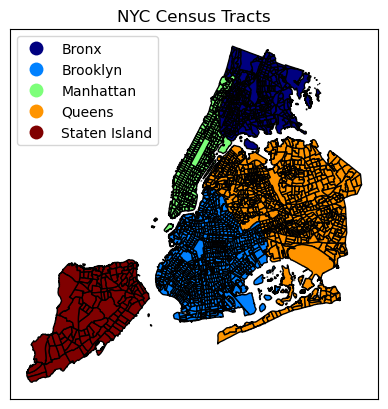

In [36]:
# TODO: kMA3pLN5r66BAnhG4hQvEr8Mi is my own token
client = Socrata("data.cityofnewyork.us", "kMA3pLN5r66BAnhG4hQvEr8Mi")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("63ge-mke6", limit=3000)

# Convert to pandas DataFrame
NYC_cencus_tract = pd.DataFrame.from_records(results)

NYC_cencus_tract = NYC_cencus_tract[NYC_cencus_tract["the_geom"].notnull()]

NYC_cencus_tract["geometry"] = NYC_cencus_tract["the_geom"].apply(lambda x: shape(x))

# TODO: CRS description
NYC_cencus_tract = gpd.GeoDataFrame(NYC_cencus_tract, geometry="geometry", crs="EPSG:4326")
NYC_cencus_tract = NYC_cencus_tract.to_crs(epsg=32618)
NYC_cencus_tract = NYC_cencus_tract.drop(columns=["the_geom", "ctlabel", "ct2020", "boroct2020", "ntaname", "nta2020", "cdta2020", "cdtaname", "shape_leng", "shape_area"])
NYC_cencus_tract["Area (km2)"] = NYC_cencus_tract.geometry.area/1000000
NYC_cencus_tract.plot(column="boroname", legend=True, cmap = "jet", edgecolor="black", legend_kwds={"loc": "upper left"})
plt.title("NYC Census Tracts")
plt.xticks([])
plt.yticks([])

plt.show()

<a id="2_2"></a>
### 2.2 Roads and Streets in NYC

#### Step 1: Get NYC road data from OSM

In [110]:
# It will take more than 3 minutes to run this cell
G = ox.graph_from_place('New York City, New York, USA')

gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)


highway_types = ["motorway", "trunk", "primary", "secondary", "tertiary", "residential", "busway"]

NYC_road = gdf_edges[gdf_edges["highway"].apply(
    lambda x: isinstance(x, str) and x in highway_types
)]
NYC_road.head()

osmid    highway  oneway reversed      length  \
u        v          key                                                       
39076461 274283981  0      25161349   motorway    True    False  819.501666   
39076490 277672005  0    1014007069   motorway    True    False  291.838695   
39076504 462122450  0     995490141   motorway    True    False  552.425691   
42421728 7784826657 0     195743153  secondary   False     True   11.805821   
         7784826658 0     420625573  secondary   False    False   11.769534   

                                                                  geometry  \
u        v          key                                                      
39076461 274283981  0    LINESTRING (-73.79475 40.78635, -73.79462 40.7...   
39076490 277672005  0    LINESTRING (-73.75709 40.76243, -73.75741 40.7...   
39076504 462122450  0    LINESTRING (-73.74416 40.75347, -73.74552 40.7...   
42421728 7784826657 0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
         7784826658 0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   

                                         name lanes maxspeed  ref bridge  \
u        v          key                                                    
39076461 274283981  0    Cross Island Parkway     2   50 mph   CI    NaN   
39076490 277672005  0    Cross Island Parkway     3   50 mph   CI    NaN   
39076504 462122450  0    Cross Island Parkway     3   50 mph   CI    NaN   
42421728 7784826657 0       Central Park West   NaN   25 mph  NaN    NaN   
         7784826658 0       West 106th Street   NaN      NaN  NaN    NaN   

                        access service tunnel width junction est_width area  \
u        v          key                                                       
39076461 274283981  0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
39076490 277672005  0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
39076504 462122450  0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
42421728 7784826657 0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
         7784826658 0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   

                        landuse  
u        v          key          
39076461 274283981  0       NaN  
39076490 277672005  0       NaN  
39076504 462122450  0       NaN  
42421728 7784826657 0       NaN  
         7784826658 0       NaN

#### Step 2: Select necessary columns

In [111]:
NYC_road = NYC_road[['osmid', 'highway', 'geometry', 'name']]
NYC_road = NYC_road.reset_index(drop=True)
NYC_road.head()

,osmid,highway,geometry,name
0,25161349,motorway,"LINESTRING (-73.79475 40.78635, -73.79462 40.7...",Cross Island Parkway
1,1014007069,motorway,"LINESTRING (-73.75709 40.76243, -73.75741 40.7...",Cross Island Parkway
2,995490141,motorway,"LINESTRING (-73.74416 40.75347, -73.74552 40.7...",Cross Island Parkway
3,195743153,secondary,"LINESTRING (-73.96004 40.79805, -73.96011 40.7...",Central Park West
4,420625573,secondary,"LINESTRING (-73.96004 40.79805, -73.96017 40.7...",West 106th Street


#### Step 3: Geo-referencing & Simplify

In [112]:
# Georeferencing
NYC_road = NYC_road.set_crs(epsg=4326)
NYC_road = NYC_road.to_crs(epsg=32618)

# Simplify the geometry
tolerance = 10
NYC_road['geometry'] = NYC_road['geometry'].simplify(tolerance)

# NYC_road.to_file('D:/Download/NYC_road.geojson', driver='GeoJSON')

NYC_road.head()

,osmid,highway,geometry,name
0,25161349,motorway,"LINESTRING (601691.23 4515738.523, 602148.812 ...",Cross Island Parkway
1,1014007069,motorway,"LINESTRING (604906.239 4513128.015, 604814.414...",Cross Island Parkway
2,995490141,motorway,"LINESTRING (606011.533 4512148.657, 605866.196...",Cross Island Parkway
3,195743153,secondary,"LINESTRING (587729.044 4516859.09, 587723.438 ...",Central Park West
4,420625573,secondary,"LINESTRING (587729.044 4516859.09, 587718.659 ...",West 106th Street


<Axes: >

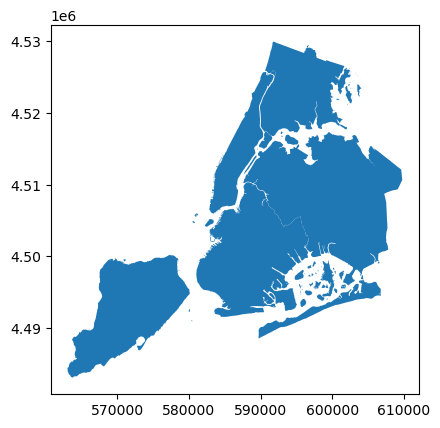

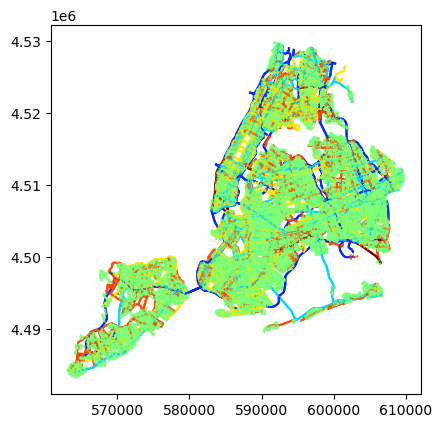

In [115]:
NYC_borough.plot()
NYC_road.plot(column="highway", cmap="jet")

<a id="2_3"></a>
### 2.3 [Geographical Points of Public Facilities](https://data.cityofnewyork.us/City-Government/Facilities-Database/ji82-xba5/about_data)

#### Selected Points of Intrests (POIs)

- **Education**
Education, Child Welfare, and Youth:
    Schools (K-12)
    Higher Education
    Vocational and Proprietary Schools

- **Parks, Gardens and Cultural Sites**
Parks, Gardens, and Historical Sites +
Libraries and Cultural Programs

- **Health**
Health and Human Services
    Health Care

- **Public Safety**
Public Safety
    Emergency Services
    Public Safety

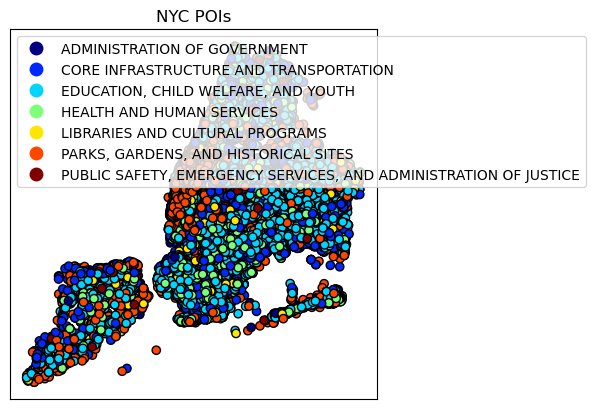

In [157]:
# https://data.cityofnewyork.us/resource/ji82-xba5.json
# TODO: kMA3pLN5r66BAnhG4hQvEr8Mi is my own token
client = Socrata("data.cityofnewyork.us", "kMA3pLN5r66BAnhG4hQvEr8Mi")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("ji82-xba5", limit=50000)

# Convert to pandas DataFrame
NYC_poi = pd.DataFrame.from_records(results)

NYC_poi = NYC_poi[NYC_poi["geometry"].notnull()]

NYC_poi['geometry'] = NYC_poi['geometry'].apply(shapely.wkt.loads)
NYC_poi = NYC_poi[['boro', 'facdomain', 'facgroup', 'facsubgrp', 'capacity', 'geometry']]

# TODO: CRS description
NYC_poi = gpd.GeoDataFrame(NYC_poi, geometry="geometry", crs="EPSG:2263")
NYC_poi = NYC_poi.to_crs(epsg=32618)
NYC_poi.plot(column="facdomain", legend=True, cmap = "jet", edgecolor="black", legend_kwds={"loc": "upper left"})
plt.title("NYC POIs")
plt.xticks([])
plt.yticks([])

plt.show()

#### Select points for analysis

In [166]:
def assign_fac_type(row):
    if row['facgroup'] in ['SCHOOLS (K-12)', 'HIGHER EDUCATION', 'VOCATIONAL AND PROPRIETARY SCHOOLS']:
        return 'Education'
    elif row['facdomain'] in ['PARKS, GARDENS, AND HISTORICAL SITES', 'LIBRARIES AND CULTURAL PROGRAMS']:
        return 'Parks, Gardens and Cultural Sites'
    elif row['facgroup'] == 'HEALTH CARE':
        return 'Public Health'
    elif row['facgroup'] in ['EMERGENCY SERVICES', 'PUBLIC SAFETY']:
        return 'Public Safety'
    else:
        return None


# 使用 apply 方法应用函数并创建新列 fac_type
NYC_poi['fac_type'] = NYC_poi.apply(assign_fac_type, axis=1)
NYC_poi = NYC_poi.dropna(subset=['fac_type'], how='any')

# 打印结果
NYC_poi.head()

,boro,facdomain,facgroup,facsubgrp,capacity,geometry,fac_type
0,STATEN ISLAND,"EDUCATION, CHILD WELFARE, AND YOUTH",SCHOOLS (K-12),PUBLIC K-12 SCHOOLS,1579,POINT (567979.616 4488486.777),Education
1,BROOKLYN,"EDUCATION, CHILD WELFARE, AND YOUTH",SCHOOLS (K-12),CHARTER K-12 SCHOOLS,0,POINT (585875.897 4495706.585),Education
2,BRONX,HEALTH AND HUMAN SERVICES,HEALTH CARE,HOSPITALS AND CLINICS,0,POINT (591105.877 4518988.575),Public Health
5,MANHATTAN,LIBRARIES AND CULTURAL PROGRAMS,CULTURAL INSTITUTIONS,OTHER CULTURAL INSTITUTIONS,0,POINT (584957.531 4510167.048),"Parks, Gardens and Cultural Sites"
7,BROOKLYN,"EDUCATION, CHILD WELFARE, AND YOUTH",SCHOOLS (K-12),PUBLIC K-12 SCHOOLS,333,POINT (589404.555 4492694.136),Education


<Axes: >

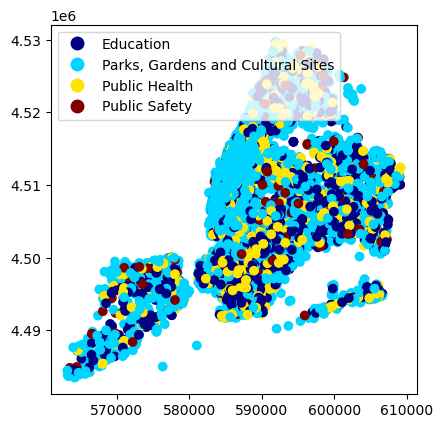

In [169]:
NYC_poi.plot(column="fac_type", legend=True, cmap = "jet", legend_kwds={"loc": "upper left"})

<a id="2_4"></a>
### 2.4 Socio-economic Indicators from ACS

In [171]:
count_zero_capacity = len(NYC_poi[NYC_poi['capacity'] == 0])
count_zero_capacity

0

<a id="2_5"></a>
### 2.5 Other Indicators Generated by Current Geospatial Data

<a id="3"></a>
## **3. Data Visualization and Analysis**


<a id="3_1"></a>
### 3.1 Spatial Accessibility Distribution of Different Public Facilities

<a id="3_2"></a>
### 3.2 Equity Assessment of Different Boroughs

<a id="3_3"></a>
### 3.3 Equity Assessment of Different Demographic Groups

<a id="3_4"></a>
### 3.4 Evaluation of Socio-economic Factors’ Impact on Accessibility

<a id="4"></a>
## **4. Conclusion**

<a id="5"></a>
## References